# Introduction

In this notebook, we will go over ways to handle multiple data in Scanpy. We will look at batch effects, ways to identify and computationally correct them, and ways to quantify the effectiveness of the correction procedure.

# Import packages

In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import harmonypy

# Concatenating multiple data in Scanpy

Often, we will have to work with more than one data/sample. The easiest way to concatenate multiple data is to load each individual data as an AnnData object and concatenate them. 

For this example case, we will load two replicates of healthy hematopoietic stem cell from this paper: https://www.nature.com/articles/s41587-023-01716-9. The data is available here:

Replicate 1: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6005302

Replicate 2: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6005304

Please scroll to the bottom of the webpages above and download: "GSM6005302_BM_CD34_Rep1_filtered_feature_bc_matrix.h5" and "GSM6005304_BM_CD34_Rep2_filtered_feature_bc_matrix.h5".



In [2]:
adata1 = sc.read_10x_h5('./data/GSM6005302_BM_CD34_Rep1_filtered_feature_bc_matrix.h5')
adata2 = sc.read_10x_h5('./data/GSM6005304_BM_CD34_Rep2_filtered_feature_bc_matrix.h5')

/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata1.var_names_make_unique()
adata2.var_names_make_unique()

In [4]:
adata1

AnnData object with n_obs × n_vars = 6973 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [5]:
adata2

AnnData object with n_obs × n_vars = 6797 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

## Concatenate the two adatas

Now that we have loaded data from both the batches, we can combine them to create one anndata object.

For details on the parameters used for the function below, please see: https://anndata.readthedocs.io/en/latest/generated/anndata.concat.html

For discussion/examples of concatenation, please see:
https://anndata.readthedocs.io/en/latest/concatenation.html 

⚠️⚠️⚠️ Note: Please pay attention to `join = 'outer'` parameter below => By choosing `'outer'`, our concatenated adata will have all the genes expressed in at least one of the adata. If you want to ensure only the genes that are expressed in both data are used in the concatenated data, you want to se `join = 'inner'`. When `join = 'outer'`, what expression counts do genes get in samples where they are not expressed? It depends on the input data matrix: if it is in sparse format they get 0, else NaN. So to ensure no NaN, we set `fill_value = 0`.

In [6]:
import anndata
adata = anndata.concat([adata1, adata2], 
                       axis = 0,                        
                       join='outer', 
                       label='batch_id', 
                       index_unique='-', 
                       fill_value=0)


# If you have more than 2 samples:
# adata = anndata.concat([adata1, adata2, adata3, adata4, adata5], 
                       # axis = 0,                        
                       # join='outer', 
                       # label='batch_id', 
                       # index_unique='-', 
                       # fill_value=0)

In [7]:
adata

AnnData object with n_obs × n_vars = 13770 × 36601
    obs: 'batch_id'

In [8]:
adata.obs

,batch_id
AAACAGCCACCTGTAA-1-0,0
AAACAGCCACTCGCTC-1-0,0
AAACAGCCACTGACCG-1-0,0
AAACAGCCATAATCAC-1-0,0
AAACATGCAAATTCGT-1-0,0
...,...
TTTGTGTTCGTCAAGT-1-1,1
TTTGTGTTCTAACTGA-1-1,1
TTTGTGTTCTCAATTC-1-1,1
TTTGTTGGTTCGCTCA-1-1,1


Since we know batch-0 is replicate-1 and batch-1 is replicate-2 data, we can rename them:

In [9]:
name_map = {'0': "Replicate-1", '1': "Replicate-2"}
adata.obs['condition'] = adata.obs['batch_id'].map(name_map)

In [10]:
adata.obs

,batch_id,condition
AAACAGCCACCTGTAA-1-0,0,Replicate-1
AAACAGCCACTCGCTC-1-0,0,Replicate-1
AAACAGCCACTGACCG-1-0,0,Replicate-1
AAACAGCCATAATCAC-1-0,0,Replicate-1
AAACATGCAAATTCGT-1-0,0,Replicate-1
...,...,...
TTTGTGTTCGTCAAGT-1-1,1,Replicate-2
TTTGTGTTCTAACTGA-1-1,1,Replicate-2
TTTGTGTTCTCAATTC-1-1,1,Replicate-2
TTTGTTGGTTCGCTCA-1-1,1,Replicate-2


Now that our data have been concatenated into a single `adata`, we can proceed with stadard analysis toolkits.

## Pre-processing

### Standard QC metrics

In [11]:
sc.pp.calculate_qc_metrics(adata, inplace = True)

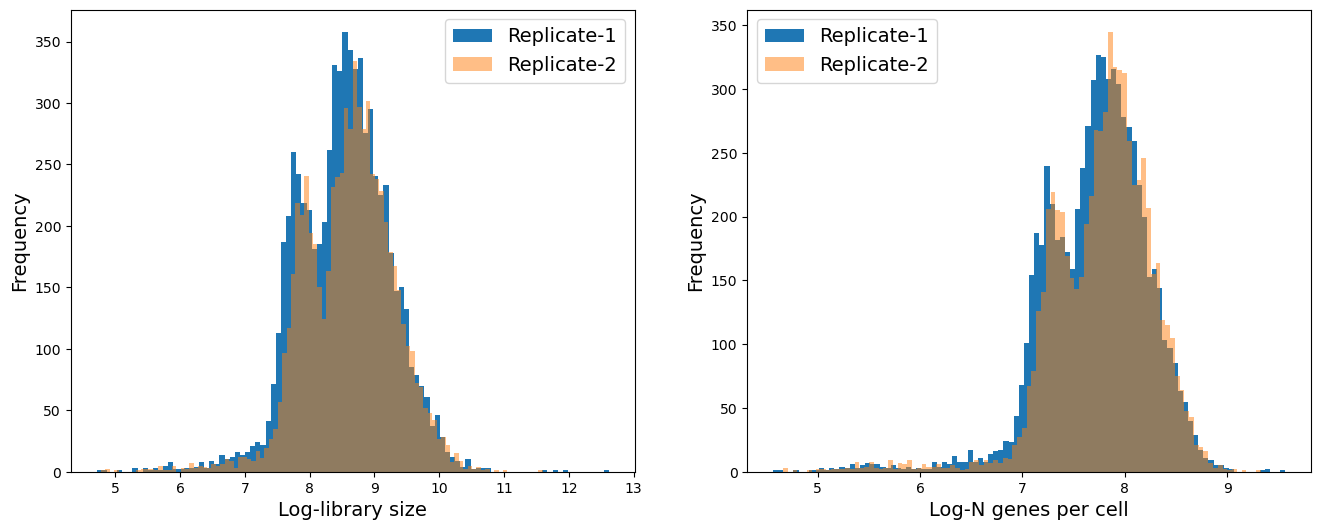

In [12]:
# Distribution of library size (total counts); number of genes per cell
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(adata.obs['log1p_total_counts'][adata.obs['batch_id'] == '0'], 100, label = "Replicate-1")
ax.hist(adata.obs['log1p_total_counts'][adata.obs['batch_id'] == '1'], 100, label = "Replicate-2", alpha = 0.5)
ax.set_xlabel('Log-library size', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.legend(fontsize = 14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(adata.obs['log1p_n_genes_by_counts'][adata.obs['batch_id'] == '0'], 100, label = "Replicate-1")
ax.hist(adata.obs['log1p_n_genes_by_counts'][adata.obs['batch_id'] == '1'], 100, label = "Replicate-2", alpha = 0.5)
ax.set_xlabel('Log-N genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.legend(fontsize = 14)

We see that on average batch-1 and batch-2 cells have similar library size and number of genes expressed per cell. 

(0.0, 500.0)

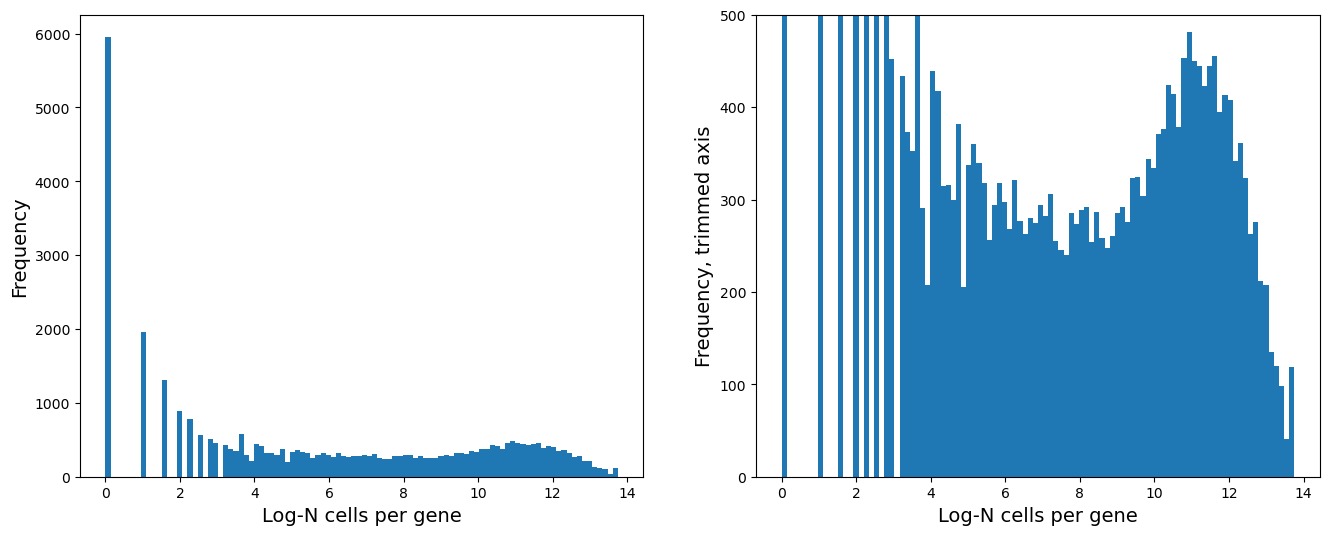

In [13]:
# Distribution of number of genes a cell is expressed in
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100)
ax.set_xlabel('Log-N cells per gene', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100)
ax.set_xlabel('Log-N cells per gene', fontsize = 14)
ax.set_ylabel('Frequency, trimmed axis', fontsize = 14)
ax.set_ylim([0, 500])

In [14]:
# Remove genes expressed in less than 5 cells in the log plot:
sc.pp.filter_genes(adata, min_cells=np.exp(5))

In [15]:
adata

AnnData object with n_obs × n_vars = 13770 × 14618
    obs: 'batch_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### % mito

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [17]:
adata.var_names[adata.var['mt']] # check to make sure only MT- genes are considered

Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object')

In [18]:
# compute the % of mito content for each cell
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [19]:
adata

AnnData object with n_obs × n_vars = 13770 × 14618
    obs: 'batch_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'

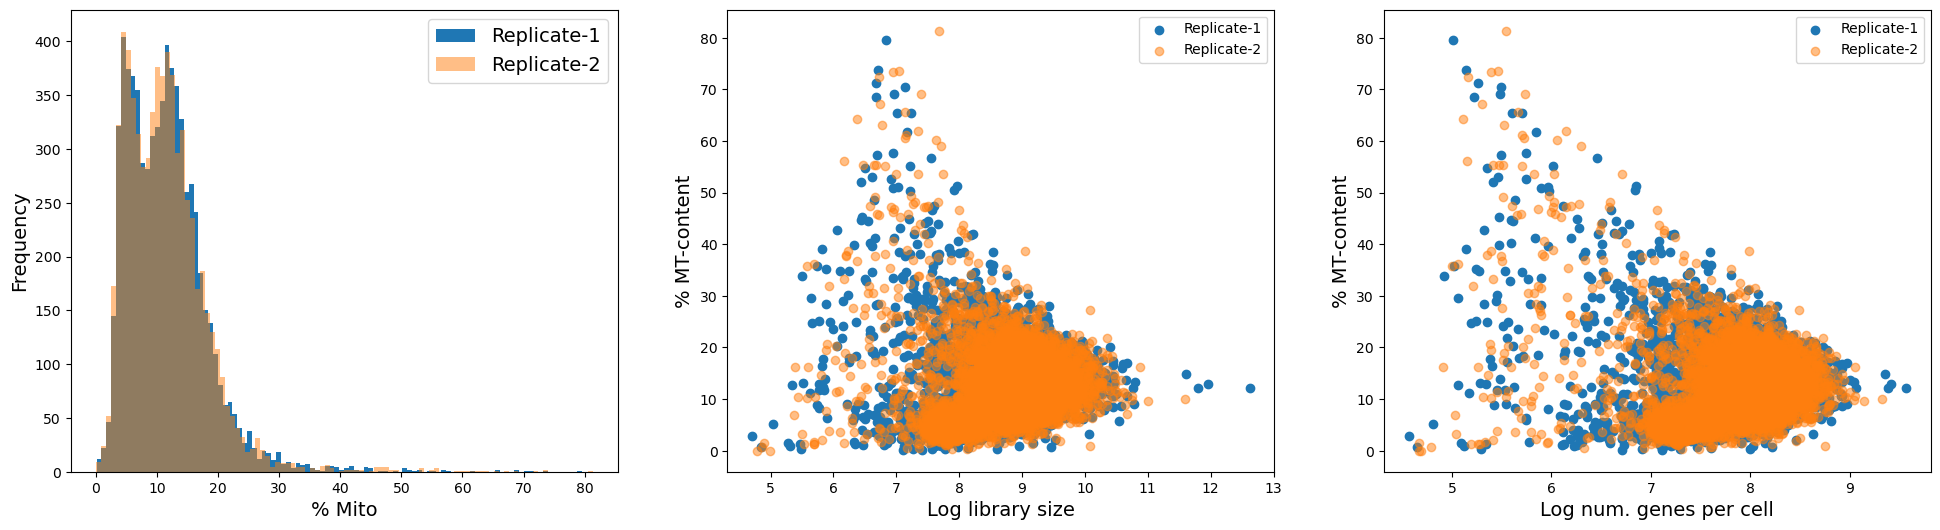

In [20]:
# Distribution of Mitochondrial content 
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs['pct_counts_mt'][adata.obs['batch_id'] == '0'], 100, label = "Replicate-1")
ax.hist(adata.obs['pct_counts_mt'][adata.obs['batch_id'] == '1'], 100, label = "Replicate-2", alpha = 0.5)
ax.set_xlabel('% Mito', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.legend(fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(adata.obs[adata.obs['batch_id'] == '0']['log1p_total_counts'], adata.obs[adata.obs['batch_id'] == '0']['pct_counts_mt'], 
           label = "Replicate-1");
ax.scatter(adata.obs[adata.obs['batch_id'] == '1']['log1p_total_counts'], adata.obs[adata.obs['batch_id'] == '1']['pct_counts_mt'], 
           label = "Replicate-2", alpha =  0.5);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)
ax.legend()

ax = fig.add_subplot(1, 3, 3)
ax.scatter(adata.obs[adata.obs['batch_id'] == '0']['log1p_n_genes_by_counts'], adata.obs[adata.obs['batch_id'] == '0']['pct_counts_mt'], 
           label = "Replicate-1");
ax.scatter(adata.obs[adata.obs['batch_id'] == '1']['log1p_n_genes_by_counts'], adata.obs[adata.obs['batch_id'] == '1']['pct_counts_mt'], 
           label = "Replicate-2", alpha =  0.5);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)
ax.legend()

In [21]:
# Remove cells with more than 25% mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < 25, :]

In [22]:
adata

View of AnnData object with n_obs × n_vars = 13337 × 14618
    obs: 'batch_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'

### Remove ribosomal genes

In [23]:
# Identify ribosomal genes - as those that start with RPS or RPL in the human genome
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))

/var/folders/z7/fxsdf_kj4m72kf_rw_g_pvtr0000gn/T/ipykernel_78467/2985208644.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))


In [24]:
adata = adata[:, ~adata.var_names.str.startswith(('RPS', 'RPL'))]

In [25]:
adata

View of AnnData object with n_obs × n_vars = 13337 × 14520
    obs: 'batch_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo'

### Scrublet for doublet detection

⚠️⚠️⚠️ As we discussed during the workshop, Scrublet and CellBender/DecontX should be performed on each sample individually before concatenating. For Scrublet, this can be ensured by supplying a batch parameter, as shown below. Other than that, we will proceed with default parameters in Scrublet.

In [26]:
sc.pp.scrublet(adata, 
               batch_key='batch_id', 
               random_state=0)

In [27]:
adata

AnnData object with n_obs × n_vars = 13337 × 14520
    obs: 'batch_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo'
    uns: 'scrublet'

### Normalization

In [28]:
# Always Store raw counts for future
adata.layers['raw_counts'] = adata.X.copy()

In [29]:
# Normalizing + log transformation

# Normalize with median library size
sc.pp.normalize_total(adata, inplace = True)

# Log transform
sc.pp.log1p(adata)

In [30]:
adata

AnnData object with n_obs × n_vars = 13337 × 14520
    obs: 'batch_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'raw_counts'

### Highly variable genes, PCA, Nearest Neighbor Graph, UMAP, Leiden

In [31]:
# HVG
sc.pp.highly_variable_genes(adata, layer = 'raw_counts', n_top_genes = 4000, flavor = 'seurat_v3')

In [32]:
# PCA
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [33]:
# Nearest neighbors on PCA
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean')

/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
# UMAP using the nearest neighbors
sc.tl.umap(adata, min_dist=0.1)

In [35]:
# Clustering using Leiden
sc.tl.leiden(adata, resolution = 1, random_state = 0)

/var/folders/z7/fxsdf_kj4m72kf_rw_g_pvtr0000gn/T/ipykernel_78467/69264152.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 1, random_state = 0)


In [36]:
adata

AnnData object with n_obs × n_vars = 13337 × 14520
    obs: 'batch_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'distances', 'connectivities'

## Visualize the data

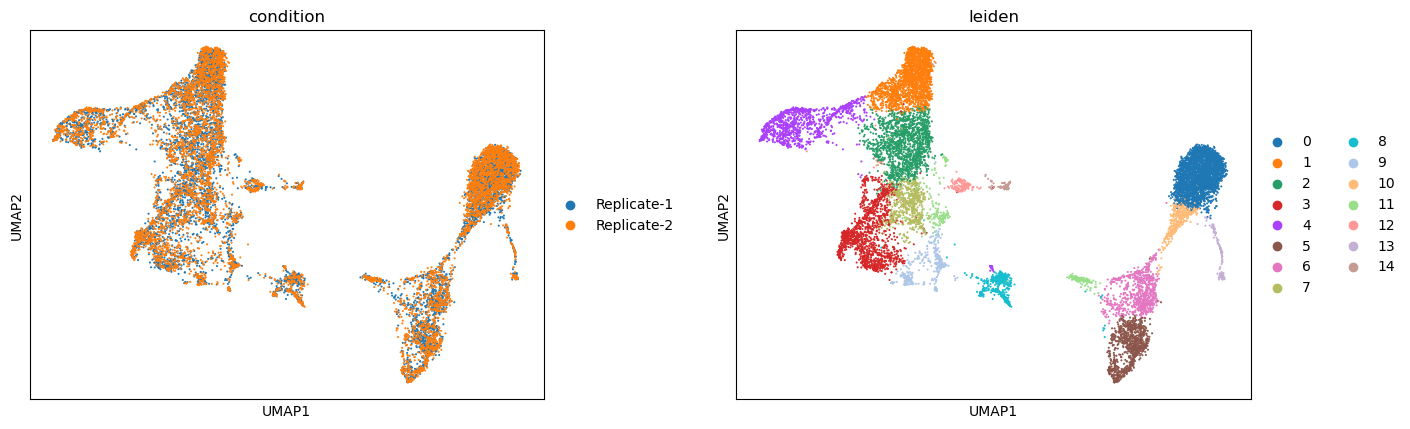

In [37]:
sc.pl.umap(adata, color = ['condition', 'leiden'], wspace = 0.25)

In the above example, the two batches/samples overlap each other on UMAP indicating that there is likely no strong batch effect present in the data.

# Handling batch effects

In the above example, we do not see any technical batch effects. But it is common to have batch effects when we combine data from different sources or conditions. To illustrate how we can handle batch effects, we will use a pair of PBMC data, which is known to have batch effect. Batch-1 is collected using 10x 3' technology, while Batch-2 is collected using 10x 5' technology. The data is taken from this publication: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9. 

The authors provide the data in an easily usable format (https://github.com/JinmiaoChenLab/Batch-effect-removal-benchmarking/tree/master/Data/dataset5).

In [38]:
input_path = './data'

## batch-1

In [39]:
adata1 = sc.read_text(os.path.join(input_path, 'b1_exprs.txt'), delimiter='\t', first_column_names=True)

In [40]:
adata1

AnnData object with n_obs × n_vars = 33694 × 8098

In [41]:
adata1.obs.head()

""
RP11-34P13.3
FAM138A
OR4F5
RP11-34P13.7
RP11-34P13.8


In [42]:
adata1.var.head()

""
data_3p-AAACCTGAGCATCATC-0
data_3p-AAACCTGAGCTAGTGG-0
data_3p-AAACCTGCACATTAGC-0
data_3p-AAACCTGCACTGTTAG-0
data_3p-AAACCTGCATAGTAAG-0


We see above that the rows are genes and the columns are cells. We can just transpose the adata:

In [43]:
adata1 = adata1.transpose()

In [44]:
adata1

AnnData object with n_obs × n_vars = 8098 × 33694

Add the author provided celltype information:

In [45]:
celltype_batch1 = pd.read_csv(os.path.join(input_path, 'b1_celltype.txt'), sep = '\t', index_col = 0)
celltype_batch1.head()

,Sample,n_counts,n_genes,batch,louvain,anno,Method,CellType
data_3p-AAACCTGAGCATCATC-0,data_3p,2394,871,0,9,B cell,10X_3prime,B cell
data_3p-AAACCTGAGCTAGTGG-0,data_3p,4520,1316,0,5,CD4 T cell,10X_3prime,CD4 T cell
data_3p-AAACCTGCACATTAGC-0,data_3p,2788,898,0,1,CD4 T cell,10X_3prime,CD4 T cell
data_3p-AAACCTGCACTGTTAG-0,data_3p,4667,1526,0,0,Monocyte_CD14,10X_3prime,Monocyte_CD14
data_3p-AAACCTGCATAGTAAG-0,data_3p,4440,1495,0,0,Monocyte_CD14,10X_3prime,Monocyte_CD14


In [46]:
for item in celltype_batch1.columns:
    adata1.obs[item] = celltype_batch1.loc[adata1.obs_names][item]

In [47]:
adata1

AnnData object with n_obs × n_vars = 8098 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'

## batch-2

In [48]:
# load and transpose
adata2 = sc.read_text(os.path.join(input_path, 'b2_exprs.txt'), delimiter='\t', first_column_names=True).transpose()

In [49]:
adata2

AnnData object with n_obs × n_vars = 7378 × 33694

Add the author provided celltype information:

In [50]:
celltype_batch2 = pd.read_csv(os.path.join(input_path, 'b2_celltype.txt'), sep = '\t', index_col = 0)
celltype_batch2.head()

,Sample,n_counts,n_genes,batch,louvain,anno,Method,CellType
data_5p-AAACCTGAGCGATAGC-1,data_5p,2712,1318,1,18,NK cell,10X_5prime,NK cell
data_5p-AAACCTGAGCTAAACA-1,data_5p,6561,2164,1,3,Monocyte_CD14,10X_5prime,Monocyte_CD14
data_5p-AAACCTGAGGGAGTAA-1,data_5p,6322,2112,1,8,Monocyte_CD14,10X_5prime,Monocyte_CD14
data_5p-AAACCTGAGTCTTGCA-1,data_5p,4528,1526,1,16,CD8 T cell,10X_5prime,CD8 T cell
data_5p-AAACCTGAGTTCGATC-1,data_5p,3426,1332,1,3,Monocyte_CD14,10X_5prime,Monocyte_CD14


In [51]:
for item in celltype_batch2.columns:
    adata2.obs[item] = celltype_batch2.loc[adata2.obs_names][item]

In [52]:
adata2

AnnData object with n_obs × n_vars = 7378 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'

## Concatenate

Let's follow the same concatenation strategy we did for the example above.

In [53]:
import anndata
adata = anndata.concat([adata1, adata2], 
                       axis = 0,                        
                       join='outer', 
                       label='batch_id', 
                       index_unique='-', 
                       fill_value=0)

In [54]:
adata

AnnData object with n_obs × n_vars = 15476 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id'

Below we see the `.obs['batch_id']` of the adata and see that the first batch is called "0" and the second batch is called "1".

In [55]:
adata.obs['batch_id']

data_3p-AAACCTGAGCATCATC-0-0    0
data_3p-AAACCTGAGCTAGTGG-0-0    0
data_3p-AAACCTGCACATTAGC-0-0    0
data_3p-AAACCTGCACTGTTAG-0-0    0
data_3p-AAACCTGCATAGTAAG-0-0    0
                               ..
data_5p-TTTGTCATCCACGTTC-1-1    1
data_5p-TTTGTCATCGCGTAGC-1-1    1
data_5p-TTTGTCATCTTAACCT-1-1    1
data_5p-TTTGTCATCTTACCGC-1-1    1
data_5p-TTTGTCATCTTGTTTG-1-1    1
Name: batch_id, Length: 15476, dtype: category
Categories (2, object): ['0', '1']

In [56]:
# check for NaN:
np.sum(np.isnan(adata.X))

0

As seen above, there are no NaN in the combined data, so we can proceed normally.

## Basic QC

In [57]:
sc.pp.calculate_qc_metrics(adata, inplace = True)

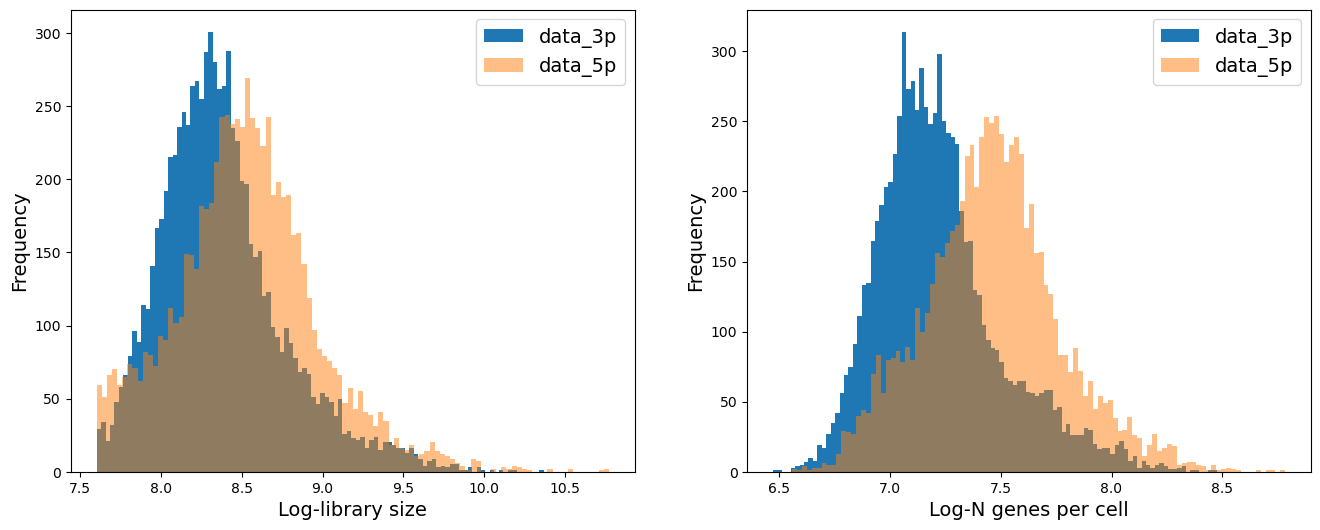

In [58]:
# Distribution of library size (total counts); number of genes per cell
fig = plt.figure(figsize = (8*2, 6*1))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for j, item in enumerate(np.unique(adata.obs['Sample'])):
    ax1.hist(adata.obs['log1p_total_counts'][adata.obs['Sample'] == item], 100, label = item, alpha = 1/(j+1))
    ax1.set_xlabel('Log-library size', fontsize = 14)
    ax1.set_ylabel('Frequency', fontsize = 14)
    ax1.legend(fontsize = 14)
    
    ax2.hist(adata.obs['log1p_n_genes_by_counts'][adata.obs['Sample'] == item], 100, label = item, alpha = 1/(j+1))
    ax2.set_xlabel('Log-N genes per cell', fontsize = 14)
    ax2.set_ylabel('Frequency', fontsize = 14)
    ax2.legend(fontsize = 14)

We see that on average batch-1 cells have higher library size and higher number of genes expressed per cell. We will keep this mind as we analyze the data.

(0.0, 500.0)

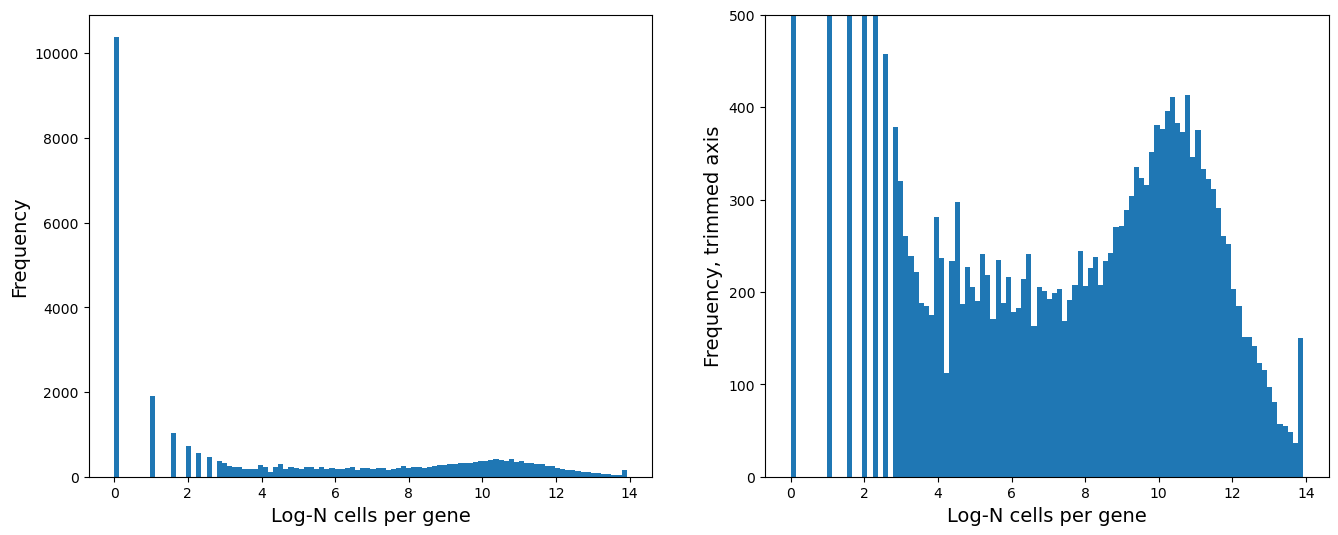

In [59]:
# Distribution of number of genes a cell is expressed in
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100)
ax.set_xlabel('Log-N cells per gene', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100)
ax.set_xlabel('Log-N cells per gene', fontsize = 14)
ax.set_ylabel('Frequency, trimmed axis', fontsize = 14)
ax.set_ylim([0, 500])

In [60]:
# Remove genes expressed in less than 5 cells on the log scale:
sc.pp.filter_genes(adata, min_cells=np.exp(5))

In [61]:
adata

AnnData object with n_obs × n_vars = 15476 × 11655
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## % mito

In [62]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [63]:
adata.var_names[adata.var['mt']] # check to make sure only MT- genes are considered

Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object')

In [64]:
# compute the % of mito content for each cell
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [65]:
adata

AnnData object with n_obs × n_vars = 15476 × 11655
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'

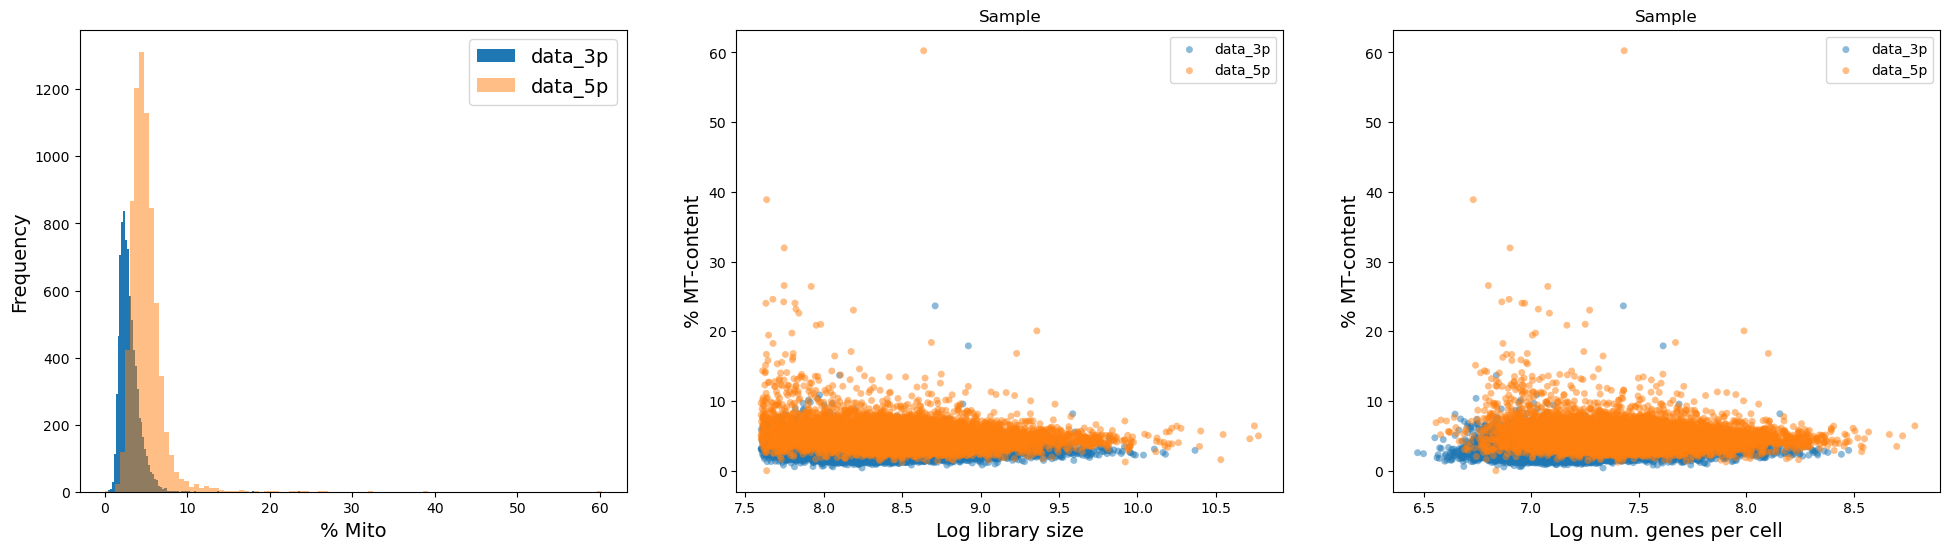

In [66]:
# Distribution of Mitochondrial content 
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs['pct_counts_mt'][adata.obs['Sample'] == 'data_3p'], 100, label = 'data_3p')
ax.hist(adata.obs['pct_counts_mt'][adata.obs['Sample'] == 'data_5p'], 100, label = "data_5p", alpha = 0.5)
ax.set_xlabel('% Mito', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.legend(fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
sc.pl.scatter(adata, x = 'log1p_total_counts', y = 'pct_counts_mt', color = 'Sample', size = 100, alpha = 0.5, ax=ax, show = False)
#ax.scatter(adata.obs[adata.obs['Sample'] == 'data_3p']['log1p_total_counts'], adata.obs[adata.obs['batch_id'] == '0']['pct_counts_mt'], 
#           label = "data_3p");
#ax.scatter(adata.obs[adata.obs['batch_id'] == '1']['log1p_total_counts'], adata.obs[adata.obs['batch_id'] == '1']['pct_counts_mt'], 
#           label = "data_5p", alpha =  0.5);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)
ax.legend()

ax = fig.add_subplot(1, 3, 3)
sc.pl.scatter(adata, x = 'log1p_n_genes_by_counts', y = 'pct_counts_mt', color = 'Sample', size = 100, alpha = 0.5, ax=ax, show = False)
#ax.scatter(adata.obs[adata.obs['batch_id'] == '0']['log1p_n_genes_by_counts'], adata.obs[adata.obs['batch_id'] == '0']['pct_counts_mt'], 
#           label = "data_3p");
#ax.scatter(adata.obs[adata.obs['batch_id'] == '1']['log1p_n_genes_by_counts'], adata.obs[adata.obs['batch_id'] == '1']['pct_counts_mt'], 
#           label = "data_5p", alpha =  0.5);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)
ax.legend()

In [67]:
# Remove cells with more than 15% mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < 15, :]

In [68]:
adata

View of AnnData object with n_obs × n_vars = 15443 × 11655
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'
    uns: 'Sample_colors'

## Remove ribosomal genes

In [69]:
# Identify ribosomal genes - as those that start with RPS or RPL in the human genome
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))

/var/folders/z7/fxsdf_kj4m72kf_rw_g_pvtr0000gn/T/ipykernel_78467/2985208644.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))


In [70]:
adata = adata[:, ~adata.var_names.str.startswith(('RPS', 'RPL'))]

In [71]:
adata

View of AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo'
    uns: 'Sample_colors'

## Normalization

In [72]:
# Normalizing + log transformation

# Store raw counts for future
adata.layers['raw_counts'] = adata.X.copy()

# Normalize with median library size
sc.pp.normalize_total(adata, inplace = True)
sc.pp.log1p(adata)

/var/folders/z7/fxsdf_kj4m72kf_rw_g_pvtr0000gn/T/ipykernel_78467/259813019.py:4: ImplicitModificationWarning: Setting element `.layers['raw_counts']` of view, initializing view as actual.
  adata.layers['raw_counts'] = adata.X.copy()


In [73]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo'
    uns: 'Sample_colors', 'log1p'
    layers: 'raw_counts'

## Highly variable genes, PCA, Nearest Neighbor Graph, UMAP, FDL, Phenograph

In [74]:
# HVG
sc.pp.highly_variable_genes(adata, layer = 'raw_counts', n_top_genes = 4000, flavor = 'seurat_v3')

In [75]:
# PCA
sc.tl.pca(adata, n_comps=100, use_highly_variable=None)

Text(0, 0.5, '% Variance Explained')

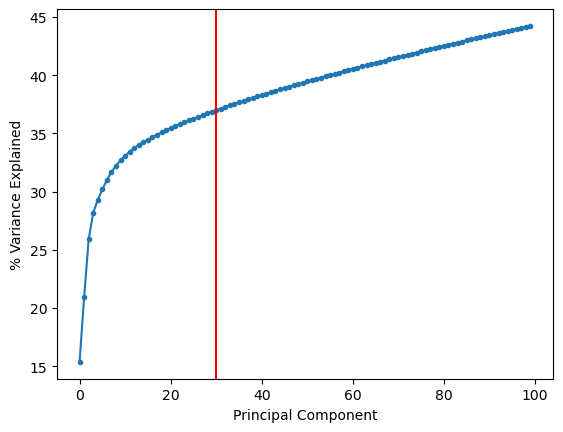

In [76]:
plt.plot(range(len(adata.uns['pca']['variance_ratio'])), np.cumsum(adata.uns['pca']['variance_ratio']) * 100, '.-')
plt.axvline(30, color = 'r')
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')

Based on the plot above, we will select 30 principal components.

In [77]:
adata.obsm['X_pca'] = adata.obsm['X_pca'][:, 0:30]

In [78]:
# Nearest neighbors on PCA
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

In [79]:
# UMAP using the nearest neighbors
sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)

In [80]:
sc.tl.leiden(adata, resolution = 1, random_state = 0, neighbors_key='neighbors_30')

In [81]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Sample_colors', 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

## Visualize the results

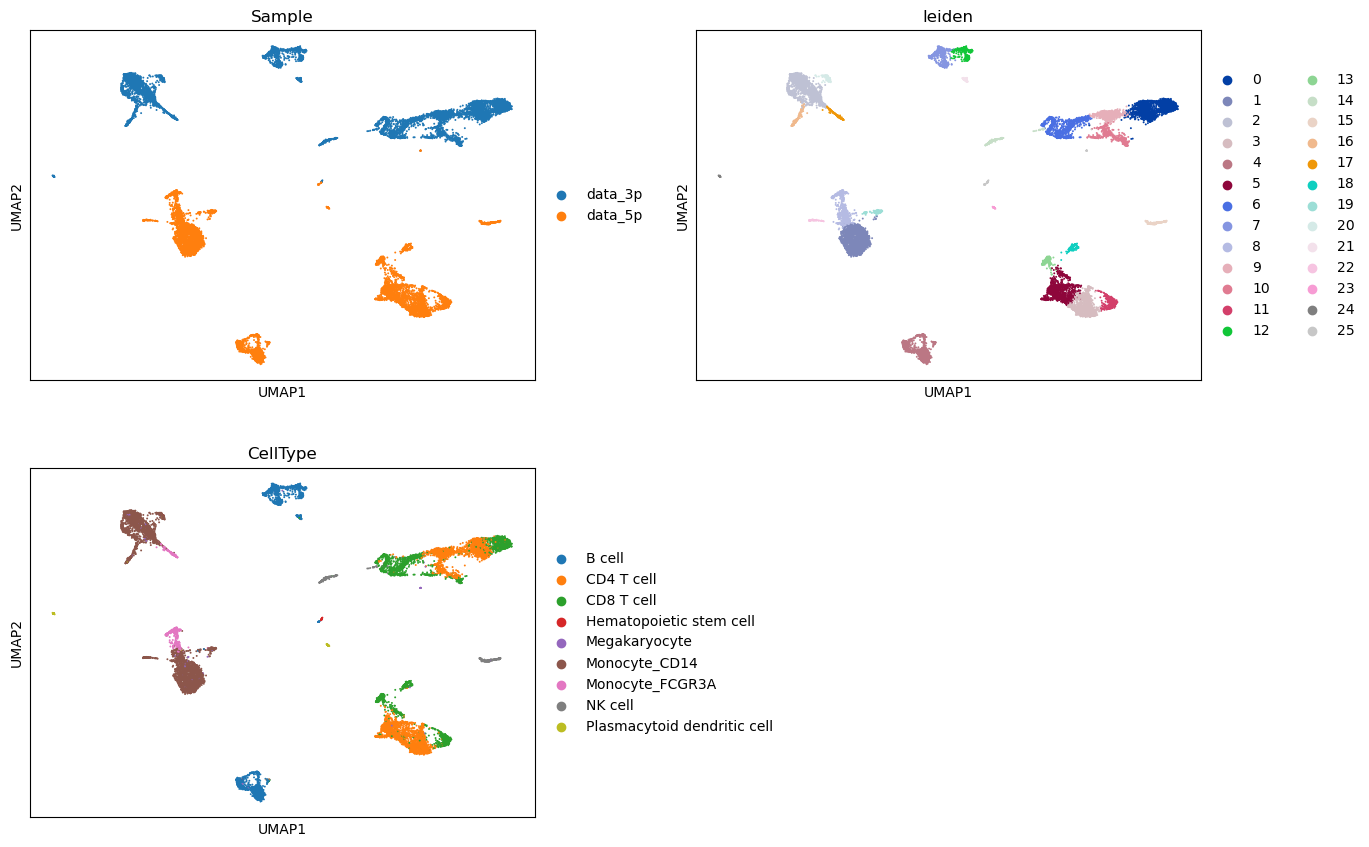

In [82]:
sc.pl.umap(adata, color = ['Sample', 'leiden', 'CellType'], wspace = 0.2, ncols = 2)

## Visualize some genes

In [83]:
genes = ['CD3E', 'CD8A', 'CD4', 'IL7R', 'MS4A1', 'CD19', 'LYZ', 'FCGR3A', 'NKG7', 'CST3', 'PPBP', 'PTPRC']

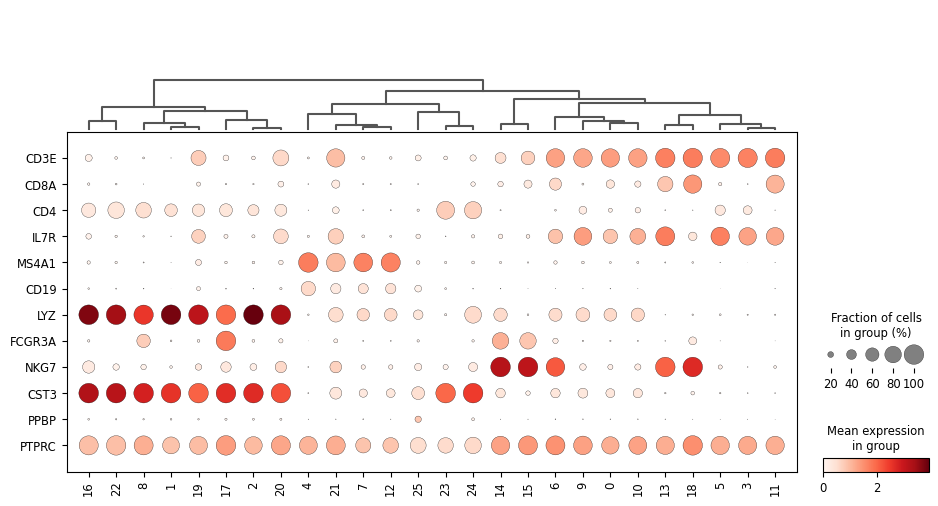

In [84]:
sc.pl.dotplot(adata, genes, groupby = 'leiden', log=False, use_raw=False, dendrogram=True, swap_axes = True)

### Highlight B cells

<Axes: title={'center': 'Sample'}, xlabel='UMAP1', ylabel='UMAP2'>

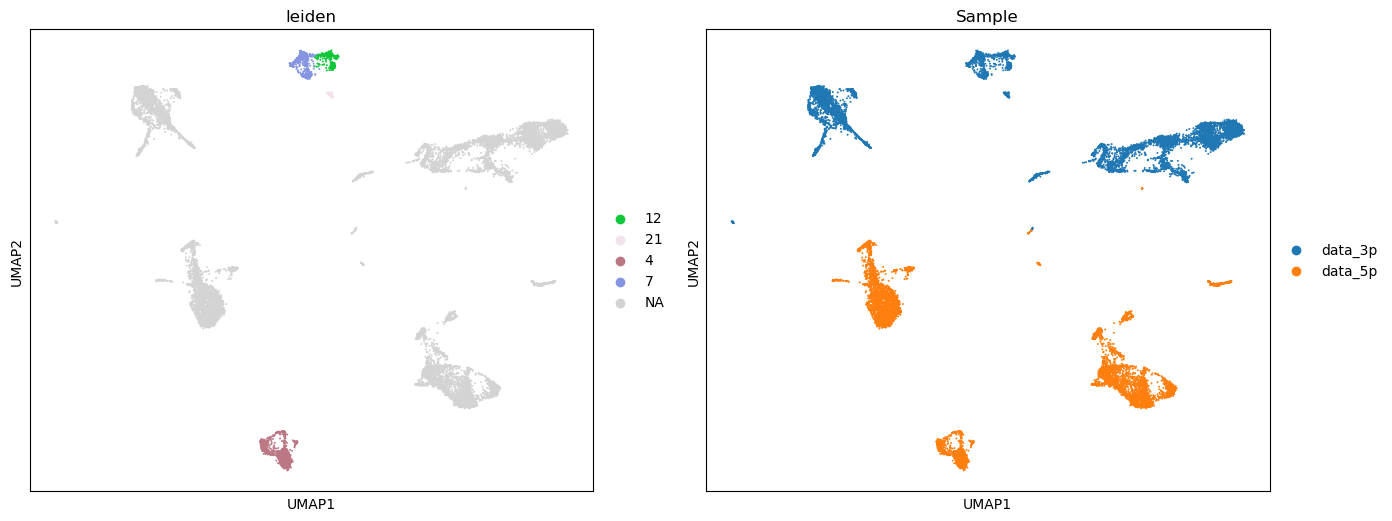

In [85]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 2, 1)
sc.pl.umap(adata, color="leiden", groups = ['4', '21', '7', '12'], ax=ax, show=False)

ax = fig.add_subplot(1, 2, 2)
sc.pl.umap(adata, color="Sample", ax=ax, show=False)


We know that these are both healthy PBMC collected using different technology, which means there must not be such striking difference only due to the batch-id. However, we can see clearly that the two samples are not overlapping with each other on UMAP, implying that there is strong batch effect between the two data. This interpretation is purely based on UMAP, so we can ask how can we explicitly confirm that there is batch effect between the samples. We will discuss a few strategies below:

## Exercise: How does UMAP look if we do batch aware HVG selection?

Let's test to see if the UMAP would look any different if we select HVG differently, like we discussed. For this task, please recompute HVG (after providing `batch_key` parameter, see API), PCA, neighbors and UMAP. 

In [86]:
# Create a new adata object so your previous results don't get over-written
adata_new = adata.copy()

In [87]:
# Calculate HVG with batch_key parameter


In [88]:
# Calculate PCA


In [89]:
# Calculate neighbors


In [90]:
# Calculate UMAP 


In [91]:
# Visualize


# Batch Effect Correction

Batch effect is a technical effect that can confound biological interpretations. We should aim to design experiments in such a way that there is as little batch effect as possible (e.g. by hashtagging samples together). But in cases such as when we wish to compare our data at hand against some other published data, it is natural to expect some batch effect. Therefore, we need to find computational solutions to correct such technical confounders. 

While there exists many methods to perform such correction, there is a common underlying assumption in all the methods: there must be some sub-populations with the same phenotype (cell type or state) across batches. Under this assumption, a majority of the methods begin by computing nearest neighbor cell or mutually nearest neighbor (MNN) between batches to identify the similar cells. Two cells are mutual nearest neighbors if they are nearest neighbors of each other. The methods interpret these pairs as consisting cells that belong to the same cell type or state despite being generated in different batches.

Here, we will discuss a popular method for batch effect correction.

Harmony: https://portals.broadinstitute.org/harmony/articles/quickstart.html
- Harmony uses Principal Component Analysis (PCA) to compress the gene expression profiles into a low-dimensional embedding.
-  In the PCA space, Harmony iteratively removes batch effects present. At each iteration, it clusters similar cells from different batches and maximizes the diversity of batches within each cluster. It then calculates a correction factor for each cell to be applied. It is good for visualization. Harmony is reported to be good for less complex batch effects.
- Note: Harmony _does not_ correct the expression of the genes in all the batches.

## Identifying batch effects: Differential expression between two batches

First, let's compute the differentially expressed genes between the batches to know what genes are different between them using Wilcoxon test (see session-3 for more details on DEG). If the differential genes are house-keeping then that signals for batch effect. If the differential genes are important celltype or cell state defining genes then perhaps the significant difference we see is real biological difference and not batch-effect.

In [92]:
sc.tl.rank_genes_groups(adata, groupby = 'batch_id', reference='rest', method='wilcoxon', use_raw = False)

In [93]:
sc.get.rank_genes_groups_df(adata, group = '0').head(20)

,names,scores,logfoldchanges,pvals,pvals_adj
0,TMSB4X,103.189400,1.543642,0.0,0.0
1,MALAT1,97.986336,2.134297,0.0,0.0
2,B2M,87.211792,1.097039,0.0,0.0
3,HLA-C,77.526741,1.228675,0.0,0.0
4,NBEAL1,67.152695,1.719272,0.0,0.0
5,RP11-347P5.1,61.072632,7.527152,0.0,0.0
6,UBA52,60.989517,0.707718,0.0,0.0
7,ATP5O,59.401093,2.521395,0.0,0.0
8,UQCRB,59.328701,1.096480,0.0,0.0
9,TRAC,56.081009,3.230725,0.0,0.0


In [94]:
sc.get.rank_genes_groups_df(adata, group = '1').head(20)

,names,scores,logfoldchanges,pvals,pvals_adj
0,AC090498.1,107.123383,3.768694,0.0,0.0
1,MT-ATP8,104.772430,7.302424,0.0,0.0
2,MT-ND4L,103.707481,3.880364,0.0,0.0
3,EEF1G,92.778610,4.641701,0.0,0.0
4,MT-CO2,80.935806,0.931731,0.0,0.0
5,IER2,80.510506,2.445022,0.0,0.0
6,NME2,79.579308,4.753057,0.0,0.0
7,GABARAP,79.300400,3.277695,0.0,0.0
8,JUN,78.906540,2.226433,0.0,0.0
9,RNASEK,77.386757,4.745258,0.0,0.0


As we can see, the genes that are discriminating between the two batches are mostly house keeping genes like MALAT1, B2M, and some mitochondrial genes like MT-ATP8, MT-ND4L. All these signal towards batch effect. But let's look deeper to see how just B cells between the two batches differ.

## Identify batch effects: Differential expression between B cells only from the two batches

In [95]:
bcell_clusters = ['4', '21', '7', '12']
adata.obs['bcell_ident'] = ['B-cells' if j in bcell_clusters else 'NA' for j in adata.obs['leiden'] ]

In [96]:
adata.obs['bcell_by_batch'] = adata.obs['bcell_ident'].astype(str) + '_' + adata.obs['Sample'].astype(str)

In [97]:
adata.obs['bcell_by_batch']

data_3p-AAACCTGAGCATCATC-0-0    B-cells_data_3p
data_3p-AAACCTGAGCTAGTGG-0-0         NA_data_3p
data_3p-AAACCTGCACATTAGC-0-0         NA_data_3p
data_3p-AAACCTGCACTGTTAG-0-0         NA_data_3p
data_3p-AAACCTGCATAGTAAG-0-0         NA_data_3p
                                     ...       
data_5p-TTTGTCATCCACGTTC-1-1         NA_data_5p
data_5p-TTTGTCATCGCGTAGC-1-1    B-cells_data_5p
data_5p-TTTGTCATCTTAACCT-1-1         NA_data_5p
data_5p-TTTGTCATCTTACCGC-1-1         NA_data_5p
data_5p-TTTGTCATCTTGTTTG-1-1         NA_data_5p
Name: bcell_by_batch, Length: 15443, dtype: object

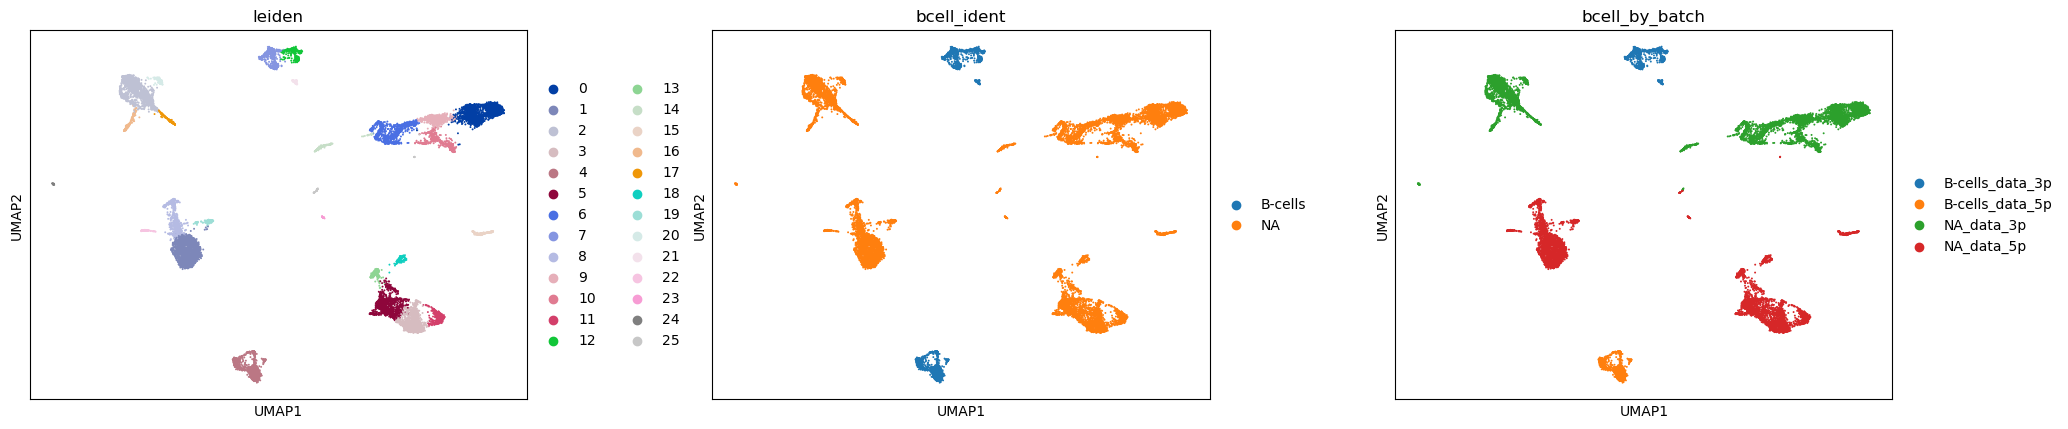

In [98]:
sc.pl.umap(adata, color = ['leiden', 'bcell_ident', 'bcell_by_batch'], wspace = 0.25)

In [99]:
sc.tl.rank_genes_groups(adata, groupby = 'bcell_by_batch', groups=['B-cells_data_3p'], reference='B-cells_data_5p', method='wilcoxon', use_raw = False, 
                        key_added = 'Bcells_by_batch_DEG')

In [100]:
sc.get.rank_genes_groups_df(adata, group = 'B-cells_data_3p', key='Bcells_by_batch_DEG').head(20)

,names,scores,logfoldchanges,pvals,pvals_adj
0,MALAT1,41.728016,1.863960,0.000000e+00,0.000000e+00
1,TMSB4X,41.003902,1.694577,0.000000e+00,0.000000e+00
2,HLA-C,36.873081,1.823431,1.248259e-297,1.603597e-294
3,B2M,36.348618,0.939200,2.763342e-289,3.194975e-286
4,HLA-DQB1,29.012554,1.277843,4.569498e-185,2.297067e-182
5,IGHD,28.825886,2.517336,1.016514e-182,4.897056e-180
6,CD52,28.614216,0.810061,4.471514e-180,2.067986e-177
7,UBA52,28.491774,0.854454,1.481315e-178,6.587293e-176
8,NBEAL1,28.476162,1.779119,2.312064e-178,9.900771e-176
9,IGHM,27.131592,1.856136,4.175803e-162,1.420019e-159


In [101]:
sc.get.rank_genes_groups_df(adata, group = 'B-cells_data_3p', key='Bcells_by_batch_DEG').tail(20)

,names,scores,logfoldchanges,pvals,pvals_adj
11542,NME2,-27.764879,-4.440977,1.152288e-169,4.594053e-167
11543,RNASEK,-28.030781,-4.813653,6.851935e-173,2.829360e-170
11544,EGR1,-29.410347,-4.814613,4.049518e-190,2.128206e-187
11545,NFKBIA,-29.914431,-2.910796,1.277464e-196,7.033352e-194
11546,GABARAP,-30.130901,-3.140524,1.908671e-199,1.103403e-196
11547,PCBP2,-30.142345,-1.574922,1.351403e-199,8.223641e-197
11548,FOS,-30.372162,-2.072090,1.281054e-202,8.228635e-200
11549,MT-CYB,-32.401142,-1.166454,2.644939e-230,1.798870e-227
11550,IER2,-33.411602,-2.851088,9.302092e-245,6.721924e-242
11551,MT-ND5,-33.557415,-1.449450,7.018622e-247,5.409954e-244


Again, we see the genes that are discriminating between the B cells among the two batches are mostly house keeping genes like MALAT1, B2M, and mitochondrial genes. All these signal towards batch effect. Now, let's ask what the differential expression of each B cell is just within each batch.

## Identifying batch effects: Differential expression between B cells to other cells in each batch

In [102]:
sc.tl.rank_genes_groups(adata, groupby = 'bcell_by_batch', groups=['B-cells_data_3p'], reference='NA_data_3p', method='wilcoxon', use_raw = False, 
                        key_added = 'data_3p_Bcells_vs_rest')

In [103]:
sc.tl.rank_genes_groups(adata, groupby = 'bcell_by_batch', groups=['B-cells_data_5p'], reference='NA_data_5p', method='wilcoxon', use_raw = False, 
                        key_added = 'data_5p_Bcells_vs_rest')

In [104]:
sc.get.rank_genes_groups_df(adata, group = 'B-cells_data_3p', key='data_3p_Bcells_vs_rest').head(20)

,names,scores,logfoldchanges,pvals,pvals_adj
0,CD79A,54.612125,6.546585,0.000000e+00,0.000000e+00
1,CD79B,54.064522,5.457804,0.000000e+00,0.000000e+00
2,CD74,53.123348,3.699935,0.000000e+00,0.000000e+00
3,MS4A1,52.223732,6.316055,0.000000e+00,0.000000e+00
4,CD37,51.484550,2.325496,0.000000e+00,0.000000e+00
5,IGHM,50.359840,6.018690,0.000000e+00,0.000000e+00
6,HLA-DPA1,49.498959,3.414352,0.000000e+00,0.000000e+00
7,HLA-DRA,49.309456,3.558466,0.000000e+00,0.000000e+00
8,HLA-DQB1,49.024670,3.307003,0.000000e+00,0.000000e+00
9,HLA-DPB1,48.885162,3.236200,0.000000e+00,0.000000e+00


In [105]:
sc.get.rank_genes_groups_df(adata, group = 'B-cells_data_5p', key='data_5p_Bcells_vs_rest').head(20)

,names,scores,logfoldchanges,pvals,pvals_adj
0,CD79A,53.604881,7.450356,0.0,0.0
1,MS4A1,53.451508,8.283983,0.0,0.0
2,CD37,53.056694,2.488385,0.0,0.0
3,CD74,52.300350,4.018080,0.0,0.0
4,CD79B,51.385487,5.565322,0.0,0.0
5,HLA-DQA1,50.941864,4.762580,0.0,0.0
6,BANK1,48.695946,7.492528,0.0,0.0
7,HLA-DQB1,48.593388,4.388478,0.0,0.0
8,LINC00926,48.515038,7.965568,0.0,0.0
9,HLA-DRA,48.144016,3.684861,0.0,0.0


As we can see, the B cells differ from other cell types within their own batch based on the same set of genes. So the B cells in the two batches are similar to each other, then why are they so distinct on UMAP? That means there is strong batch effect in the data. 

## Batch effect correction - Harmony

Harmony is another popular method for correcting batch effect in single-cell RNA-sequencing data. As discussed in the beginning, Harmony iteratively removes batch effects in the PCA space. In each iteration, it clusters similar cells from different batches and maximizing the diversity of batches within each cluster; it then calculates a correction factor for each cell to be applied. While it is a fast method, there are a couple caveats: 1) Since it operates only on the PCA space, any non-linear association between features could be missed or altered; and 2) Harmony does not provide a corrected gene expression matrix. Therefore, the output of Harmony can only be used for visualization and clustering but not for differential expression analysis or any gene centric analysis, since one does not get a corrected expression matrix back. One would need to be careful to perform downstream analysis with Harmony.

Harmony is implemented in Scanpy: https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.harmony_integrate.html. 

In [106]:
adata = sc.read_h5ad('./data/batch_effect_data.h5ad')

In [107]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'bcell_ident', 'bcell_by_batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Bcells_DEG', 'Bcells_by_batch_DEG', 'CellType_colors', 'Sample_colors', 'X_umap_harmony', 'X_umap_scvi', '_scvi_manager_uuid', '_scvi_uuid', 'batch_id_colors', 'bcell_by_batch_colors', 'bcell_ident_colors', 'data_3p_Bcells_vs_rest', 'data_5p_Bcells_vs_rest', 'dendrogram_leiden', '

In [108]:
sc.external.pp.harmony_integrate(adata, 
                                 key = 'batch_id', 
                                 basis='X_pca', 
                                 adjusted_basis='X_pca_harmony')

2025-10-02 22:52:39,645 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-02 22:52:43,665 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-02 22:52:43,727 - harmonypy - INFO - Iteration 1 of 10
2025-10-02 22:52:46,806 - harmonypy - INFO - Iteration 2 of 10
2025-10-02 22:52:49,156 - harmonypy - INFO - Iteration 3 of 10
2025-10-02 22:52:51,642 - harmonypy - INFO - Iteration 4 of 10
2025-10-02 22:52:53,592 - harmonypy - INFO - Iteration 5 of 10
2025-10-02 22:52:54,595 - harmonypy - INFO - Iteration 6 of 10
2025-10-02 22:52:55,431 - harmonypy - INFO - Iteration 7 of 10
2025-10-02 22:52:56,347 - harmonypy - INFO - Iteration 8 of 10
2025-10-02 22:52:57,183 - harmonypy - INFO - Converged after 8 iterations


In [109]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'bcell_ident', 'bcell_by_batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Bcells_DEG', 'Bcells_by_batch_DEG', 'CellType_colors', 'Sample_colors', 'X_umap_harmony', 'X_umap_scvi', '_scvi_manager_uuid', '_scvi_uuid', 'batch_id_colors', 'bcell_by_batch_colors', 'bcell_ident_colors', 'data_3p_Bcells_vs_rest', 'data_5p_Bcells_vs_rest', 'dendrogram_leiden', '

### Recompute the neighbors and UMAP on the above computed X_pca_harmony

In [110]:
# Nearest neighbors on PCA_harmony
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca_harmony', metric='euclidean', key_added='neighbors_30_harmony')

In [111]:
# UMAP using the nearest neighbors
# Make sure to provide key_added parameter below to prevent overwriting original UMAP
sc.tl.umap(adata, neighbors_key = 'neighbors_30_harmony', min_dist=0.1, key_added='X_umap_harmony')

In [112]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'bcell_ident', 'bcell_by_batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Bcells_DEG', 'Bcells_by_batch_DEG', 'CellType_colors', 'Sample_colors', 'X_umap_harmony', 'X_umap_scvi', '_scvi_manager_uuid', '_scvi_uuid', 'batch_id_colors', 'bcell_by_batch_colors', 'bcell_ident_colors', 'data_3p_Bcells_vs_rest', 'data_5p_Bcells_vs_rest', 'dendrogram_leiden', '

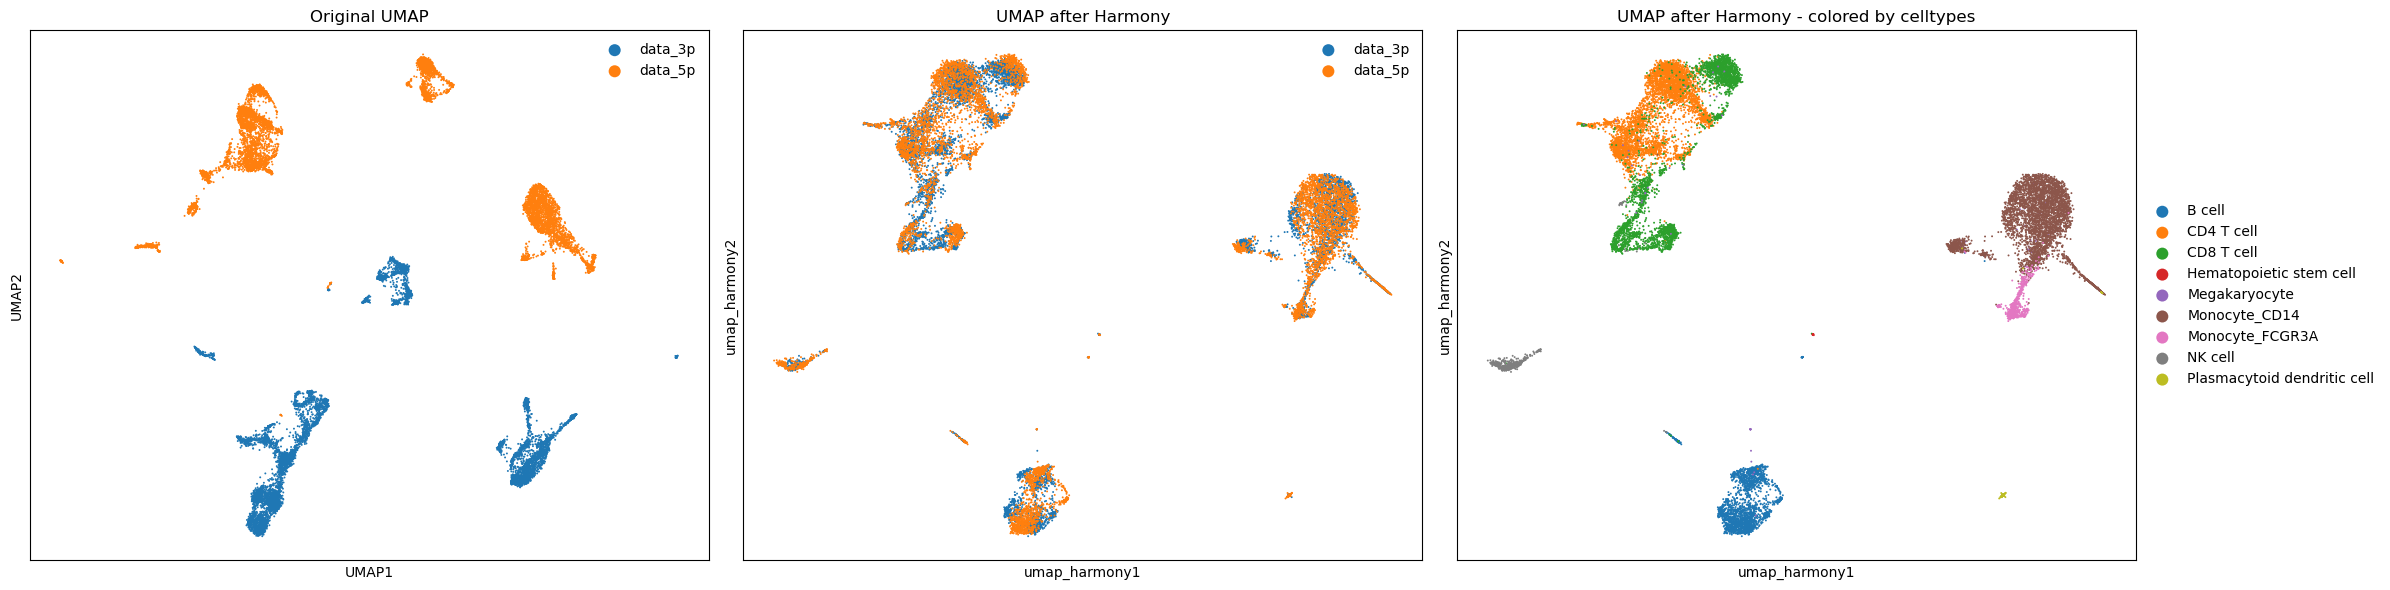

In [113]:
fig = plt.figure(figsize = (8*3, 6))
ax = fig.add_subplot(1, 3, 1)
sc.pl.scatter(adata, basis = 'umap', color="Sample", ax=ax, show=False, legend_loc = 'upper right')
ax.set_title('Original UMAP')

ax = fig.add_subplot(1, 3, 2)
sc.pl.scatter(adata, basis = 'umap_harmony', color="Sample", ax=ax, show=False, legend_loc = 'upper right')
ax.set_title('UMAP after Harmony')

ax = fig.add_subplot(1, 3, 3)
sc.pl.scatter(adata, basis = 'umap_harmony', color="CellType", ax=ax, show=False)
ax.set_title('UMAP after Harmony - colored by celltypes')
fig.tight_layout()

## Batch effect Correction with scvi-tools

scVI-tools is an "end-to-end" tool for analyzing single-cell RNA-seq data. It offers methods for dimensionality reduction, dataset integration (and batch effect correction), differential expression, automated annotation. It is statistically rigorous and has various pros and cons for different tasks. Here we will employ scvi-tools to seek batch effect correction.

In [114]:
import scvi

In [115]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'bcell_ident', 'bcell_by_batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Bcells_DEG', 'Bcells_by_batch_DEG', 'CellType_colors', 'Sample_colors', 'X_umap_harmony', 'X_umap_scvi', '_scvi_manager_uuid', '_scvi_uuid', 'batch_id_colors', 'bcell_by_batch_colors', 'bcell_ident_colors', 'data_3p_Bcells_vs_rest', 'data_5p_Bcells_vs_rest', 'dendrogram_leiden', '

In [116]:
# Setup for scVI
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw_counts",
    categorical_covariate_keys=["batch"]
)

In [117]:
# Create a model
model = scvi.model.SCVI(adata)

In [118]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [119]:
import os
original_slurm_ntasks = os.environ.get("SLURM_NTASKS")
print(original_slurm_ntasks)
os.environ["SLURM_NTASKS"] = "1"

None


In [120]:
# Train the model
model.train(max_epochs=10, accelerator="cpu", devices=1) # <- For better results set max_epochs = 200

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
SLURM auto-requeueing enabled. Setting signal handlers.
/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.44s/it, v_num=1, train_loss_step=4.49e+3, train_loss_epoch=4.48e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.46s/it, v_num=1, train_loss_step=4.49e+3, train_loss_epoch=4.48e+3]


Now that we have trained the model, we can extract the latent dimensions:

In [121]:
latent = model.get_latent_representation()

In [122]:
print(latent.shape)

(15443, 10)


In [123]:
# store the latent as X_scvi in adata
adata.obsm["X_scVI"] = latent

scvi also gives you normalized expression:

In [124]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

In [125]:
adata.layers["scvi_normalized"].shape

(15443, 11562)

### Recompute the neighbors and UMAP on the above computed X_scVI

We first need to compute neighbors and UMAP using scvi latent representation:

In [126]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors= 30, key_added = 'scVI')

# UMAP using the nearest neighbors
sc.tl.umap(adata, neighbors_key = 'scVI', min_dist=0.1, key_added = "X_umap_scvi")

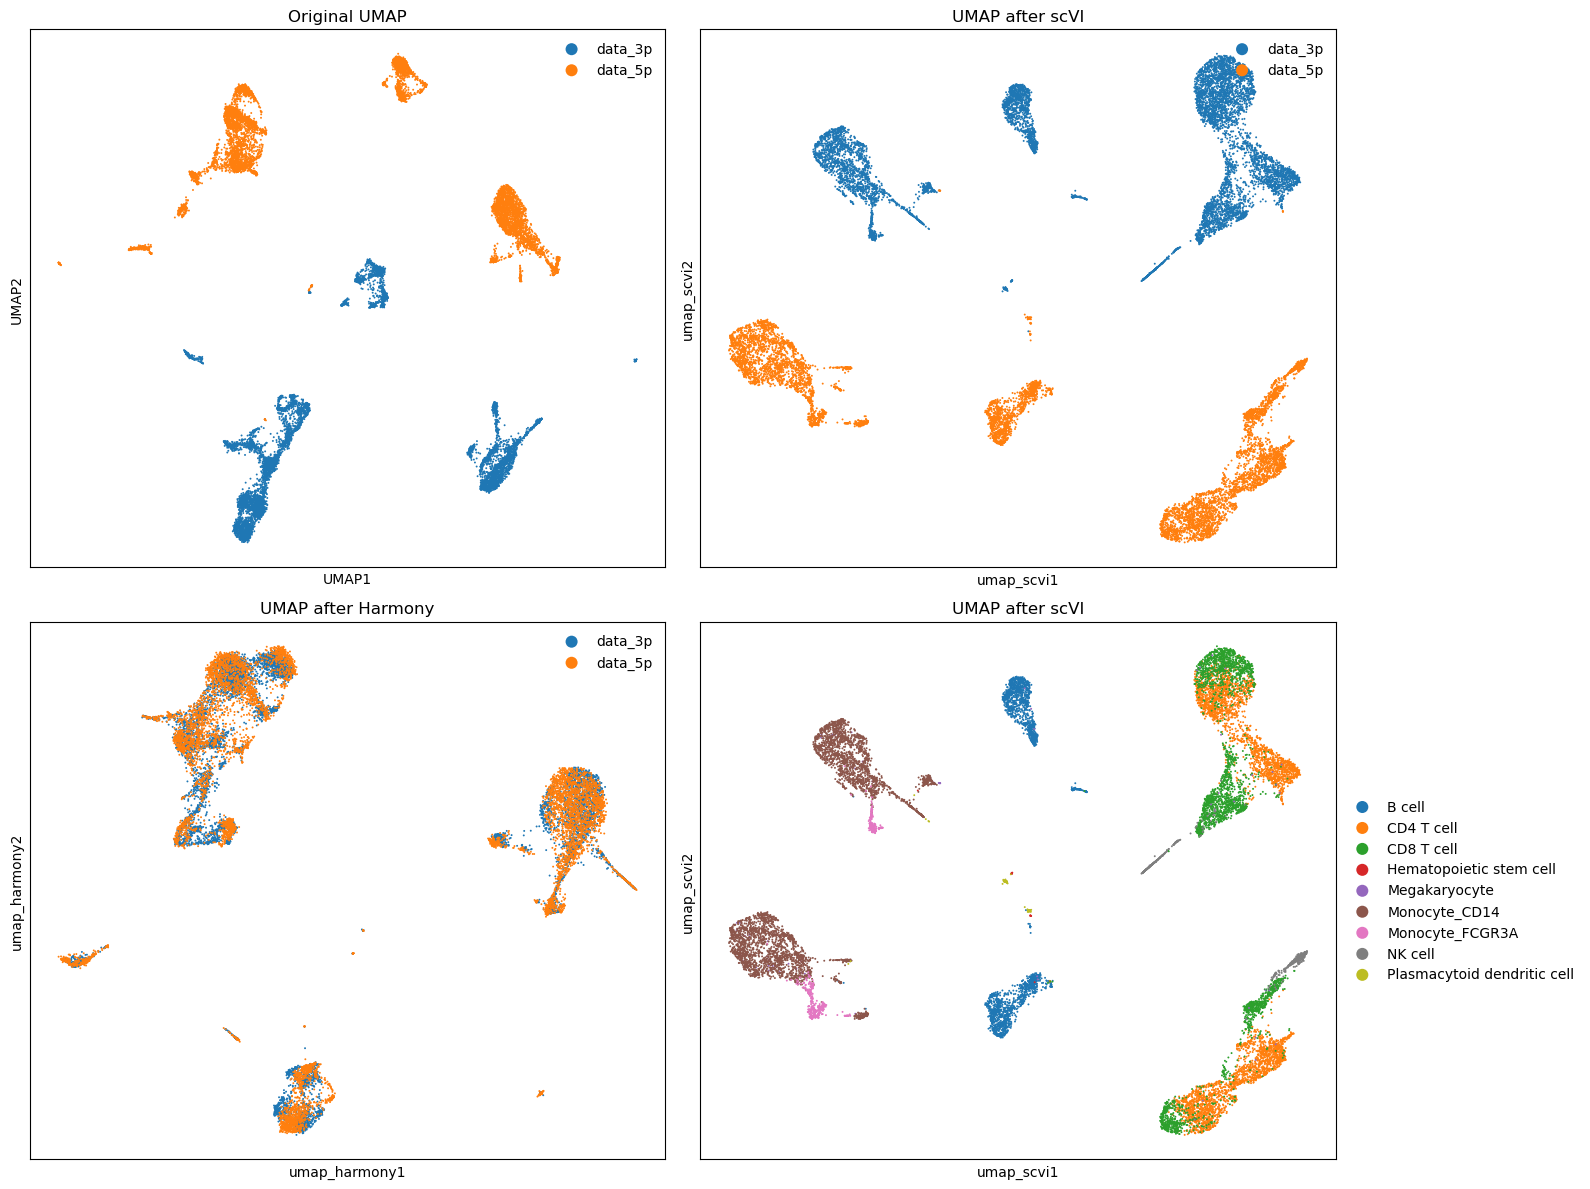

In [127]:
fig = plt.figure(figsize = (8*2, 6*2))
ax = fig.add_subplot(2, 2, 1)
sc.pl.scatter(adata, basis = 'umap', color="Sample", ax=ax, show=False, legend_loc = 'upper right')
ax.set_title('Original UMAP')

ax = fig.add_subplot(2, 2, 2)
sc.pl.scatter(adata, basis = 'umap_scvi', color="Sample", ax=ax, show=False, legend_loc = 'upper right')
ax.set_title('UMAP after scVI')

ax = fig.add_subplot(2, 2, 3)
sc.pl.scatter(adata, basis = 'umap_harmony', color="Sample", ax=ax, show=False, legend_loc = 'upper right')
ax.set_title('UMAP after Harmony')

ax = fig.add_subplot(2, 2, 4)
sc.pl.scatter(adata, basis = 'umap_scvi', color="CellType", ax=ax, show=False)
ax.set_title('UMAP after scVI')
fig.tight_layout()

⚠️⚠️⚠️ The results from scVI do not as good because we set number of epochs to 50 - to save time. For better results, please set it to a higher value.

In [128]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'bcell_ident', 'bcell_by_batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Bcells_DEG', 'Bcells_by_batch_DEG', 'CellType_colors', 'Sample_colors', 'X_umap_harmony', 'X_umap_scvi', '_scvi_manager_uuid', '_scvi_uuid', 'batch_id_colors', 'bcell_by_batch_colors', 'bcell_ident_colors', 'data_3p_Bcells_vs_rest', 'data_5p_Bcells_vs_rest', 'dendrogram_leiden', '

# Ideas to quantifying effectiveness of batch effect correction

## Entropy of mixture

Aside from visually comparing the UMAPs (with cell type/gene expression information) before and after batch correction, we can also quantify how effective our batch correction is using `batch entropy`.

At a high level, batch entropy is an indicator of the degree of mixture among cells of different batches. For a given cell X, we first compute its nearest neighbors and identify their batch ids. If this neighborhood around X is well-mixed with cells from different batches then it means that the cells similar to X are present in many different batches and that the batches align well. This would imply that the more heterogeneous (in terms of batch id) the neighborhood of each cell is, the less batch effect there is. We quantify this notion of heterogeneity using entropy. 

Computationally:
- Given a cell $i$, we first compute $k$ nearest neighbors around it and their batch id
- We compute the fraction (out of $k$) of cells from each batch id in that neighborhood
- This represents the probability vector of batch distribution around cell $i$ (Call it $p_i$)
- We repeat this for all cells
- We then calculate the Shannon entropy: $$H = -\sum_{i=1}^N p_i \log_2(p_i),$$ where N is the total number of cells.

Thus, if there are obvious batch effects, we expect cells of the same batch to be near each other (more homogenous) and distant from other batches, so the overall batch entropy distribution across all cells will be low. After effective batch correction, we expect the cells to be more mixed (more heterogenous), and the overall batch entropy distribution across cells to be higher.

Like always, we will compute the nearest neighbors on PCA space.

### Before correction

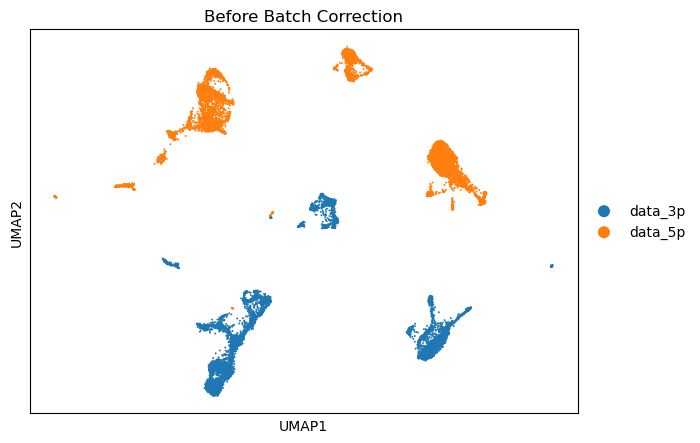

In [129]:
sc.pl.scatter(adata, color = ['Sample'], title = 'Before Batch Correction', basis = 'umap')

In [130]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'bcell_ident', 'bcell_by_batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Bcells_DEG', 'Bcells_by_batch_DEG', 'CellType_colors', 'Sample_colors', 'X_umap_harmony', 'X_umap_scvi', '_scvi_manager_uuid', '_scvi_uuid', 'batch_id_colors', 'bcell_by_batch_colors', 'bcell_ident_colors', 'data_3p_Bcells_vs_rest', 'data_5p_Bcells_vs_rest', 'dendrogram_leiden', '

Since we already have computed the nearest neighbors (`adata.obsp['neighbors_30_distances']`), we simply need to get the batch-id of each cell in each of the neighborhoods and compute entropy. We can use the following function to compute entropy:

In [131]:
import scipy
# a function to compute entropy for a cell given the batch labels of cells in its neighborhood
def compute_entropy(labels, base=None):
    value, counts = np.unique(labels, return_counts=True)
    return scipy.stats.entropy(counts, base=base)

# a function to convert scanpy's nearest neighbor output to a more standard matrix 
def create_nn_mat(adata_temp, key):
    [row, col, val] = scipy.sparse.find(adata_temp.obsp[key])
    nn_mat = np.zeros(shape = (adata_temp.shape[0], sum(row == 0)))
    for item in range(adata_temp.shape[0]):
        nn_mat[item, :] = col[row == item]
    return nn_mat

In [132]:
# convert scanpy's nearest neighbor distance to a standard matrix
nn_mat = create_nn_mat(adata, key = 'neighbors_30_distances')

In [133]:
# compute entropy before correction
entropy_before = []
for r in range(nn_mat.shape[0]):
    labels = adata.obs['batch'].iloc[nn_mat[r]]
    entropy_val = compute_entropy(labels, base = 2)
    entropy_before.append(entropy_val)

### After correction

For illustration, let's take Harmony integrated as an example of after batch effect correction:

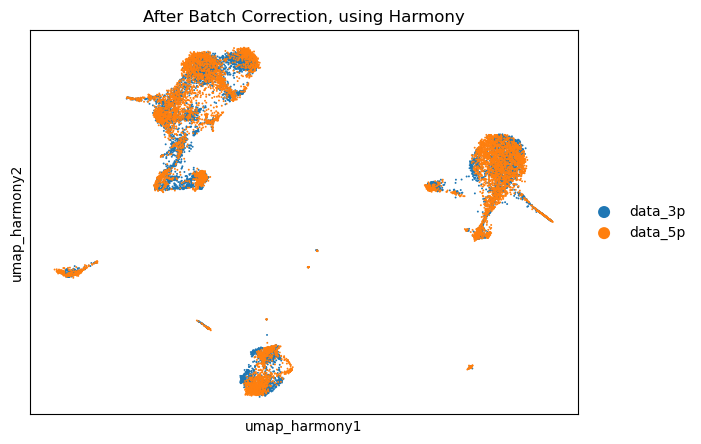

In [134]:
sc.pl.scatter(adata, basis = 'umap_harmony', color = ['Sample'], title = 'After Batch Correction, using Harmony')

In [135]:
nn_mat_after = create_nn_mat(adata, key = 'neighbors_30_harmony_distances') # <- make sure correct key is used

In [136]:
entropy_after = []
for r in range(nn_mat_after.shape[0]):
    entropy_after.append(compute_entropy(adata.obs['batch'].iloc[nn_mat_after[r]], base = 2))

Text(0.5, 1.0, 'After Harmony correction')

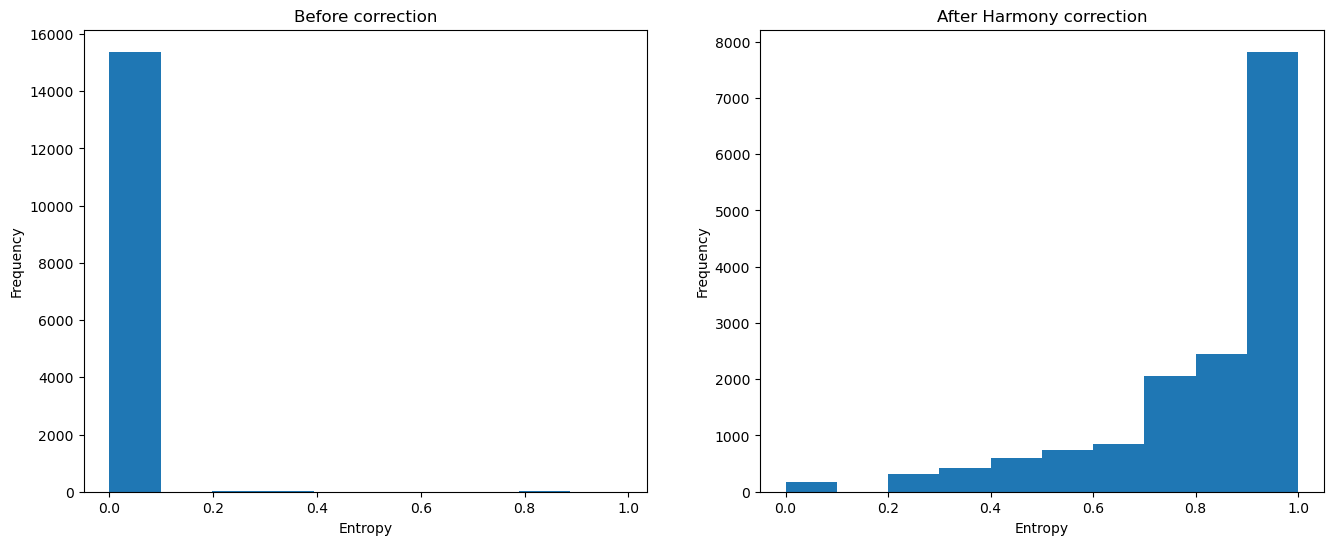

In [137]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 2, 1)
ax.hist(entropy_before, 10);
ax.set_xlabel('Entropy')
ax.set_ylabel('Frequency')
ax.set_title('Before correction')

ax = fig.add_subplot(1, 2, 2)
ax.hist(entropy_after, 10);
ax.set_xlabel('Entropy')
ax.set_ylabel('Frequency')
ax.set_title('After Harmony correction')


Text(0.5, 1.0, 'Before correction')

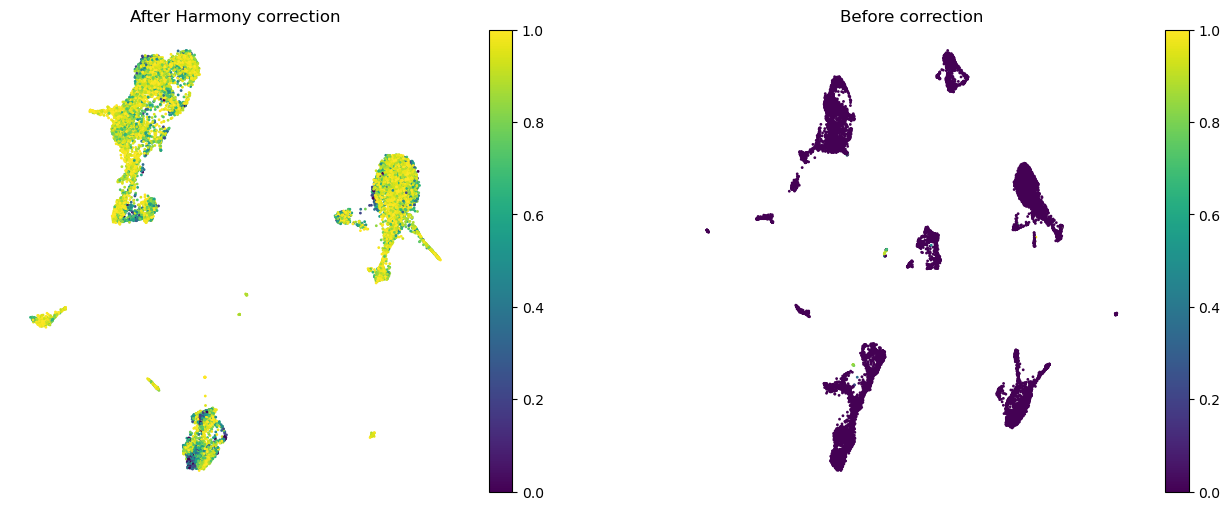

In [138]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 2, 1)
im1 = ax.scatter(adata.obsm['X_umap_harmony'][:, 0], adata.obsm['X_umap_harmony'][:, 1], s = 1, c = entropy_after, 
                 vmin = 0, vmax = 1);
ax.axis('off')
fig.colorbar(im1)
ax.set_title('After Harmony correction')

ax = fig.add_subplot(1, 2, 2)
im1 = ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s = 1, c = entropy_before, 
                 vmin = 0, vmax = 1);
ax.axis('off')
fig.colorbar(im1)
ax.set_title('Before correction')

## scIB

scIB (single cell Integration Benchmark) is a concentrated effort to design metrics for quality of batch effect correction and integration in single-cell data sets. You can read more in the original publication: https://www.nature.com/articles/s41592-021-01336-8  and associated website: https://theislab.github.io/scib-reproducibility/overview.html

Please also see comprehensive documentation: https://scib.readthedocs.io/en/latest/.

Here, we will use this to assess whuch method works best for the data above.

In [139]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

In [140]:
adata

AnnData object with n_obs × n_vars = 15443 × 11562
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'bcell_ident', 'bcell_by_batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Bcells_DEG', 'Bcells_by_batch_DEG', 'CellType_colors', 'Sample_colors', 'X_umap_harmony', 'X_umap_scvi', '_scvi_manager_uuid', '_scvi_uuid', 'batch_id_colors', 'bcell_by_batch_colors', 'bcell_ident_colors', 'data_3p_Bcells_vs_rest', 'data_5p_Bcells_vs_rest', 'dendrogram_leiden', '

In [141]:
help(Benchmarker)

Help on class Benchmarker in module scib_metrics.benchmark._core:

class Benchmarker(builtins.object)
 |  Benchmarker(adata: anndata._core.anndata.AnnData, batch_key: str, label_key: str, embedding_obsm_keys: list[str], bio_conservation_metrics: scib_metrics.benchmark._core.BioConservation | None = BioConservation(isolated_labels=True, nmi_ari_cluster_labels_leiden=False, nmi_ari_cluster_labels_kmeans=True, silhouette_label=True, clisi_knn=True), batch_correction_metrics: scib_metrics.benchmark._core.BatchCorrection | None = BatchCorrection(bras=True, ilisi_knn=True, kbet_per_label=True, graph_connectivity=True, pcr_comparison=True), pre_integrated_embedding_obsm_key: str | None = None, n_jobs: int = 1, progress_bar: bool = True, solver: str = 'arpack')
 |
 |  Benchmarking pipeline for the single-cell integration task.
 |
 |  Parameters
 |  ----------
 |  adata
 |      AnnData object containing the raw count data and integrated embeddings as obsm keys.
 |  batch_key
 |      Key in `ada

In [142]:
bm = Benchmarker(adata,
                 batch_key="batch_id",
                 label_key="CellType",
                 bio_conservation_metrics=BioConservation(),
                 batch_correction_metrics=BatchCorrection(),
                 embedding_obsm_keys=["X_pca",
                                      "X_pca_harmony", 
                                      "X_scVI"])
bm.benchmark()

/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(
Metrics:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:22<00:11,  3.82s/it, Batch correction: graph_connectivity]/Users/chunj/miniconda3/envs/scgw_4/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  33%|█████████████████████████████████████████████████▎                                                                         

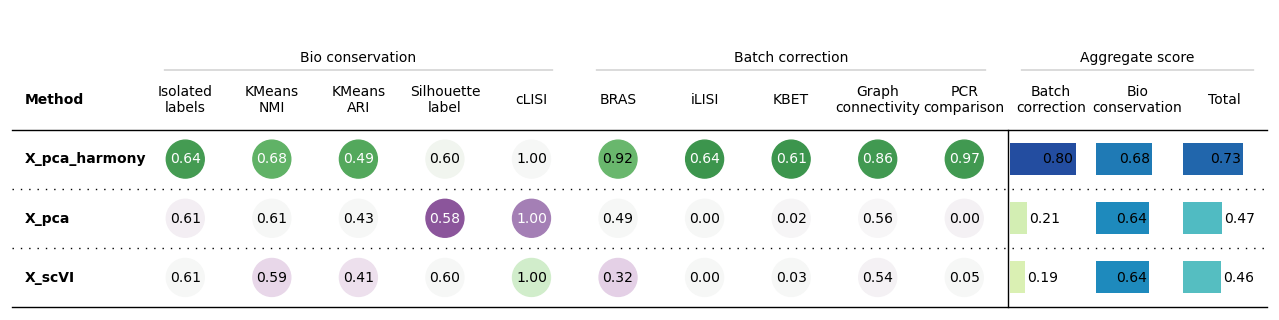

In [143]:
bm.plot_results_table(min_max_scale=False)

Based on our use of scib-metrics (default), Harmony seems to perform the best. 

# Save for later

In [144]:
adata.write_h5ad('./data/batch_effect_corrected_data.h5ad')